In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [83]:
df=pd.read_csv('train.csv')
display(df.head())
display(df.describe().head())
display(df.tail())


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,NaN,Attchd,1950.0,Unf,1,240,TA,TA,Y,366,0,112,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,6,1965,1965,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,Gd,TA,CBlock,TA,TA,No,BLQ,830,LwQ,290,136,1256,GasA,Gd,Y,SBrkr,1256,0,0,1256,1,0,1,1,3,1,TA,6,Typ,0,NaN,Attchd,1965.0,Fin,1,276,TA,TA,Y,736,68,0,0,0,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [84]:
count=df.isna().sum()
count=count.loc[(lambda x :x>0)].apply(lambda x:np.round(x/df.shape[0]*100,2))

df['SalePrice'].mean()
    

np.float64(180921.19589041095)

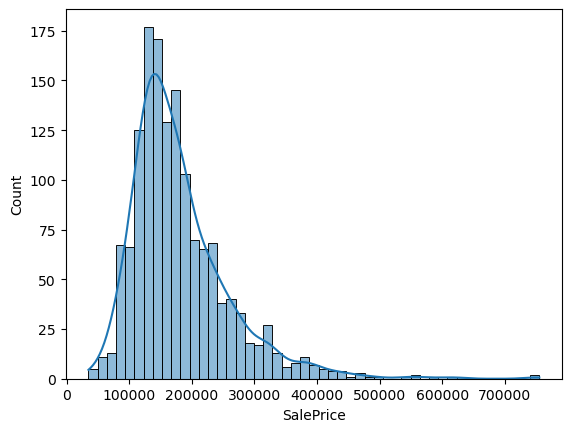

In [85]:
sns.histplot(df,x='SalePrice',kde=True)
plt.show()

In [86]:
df=df.drop(columns=['Id','Alley','PoolQC','Fence','MiscFeature'])
df=df.dropna(subset=['MasVnrArea','Electrical'])


In [87]:
count=df.isna().sum()
count=count.loc[(lambda x :x>0)].apply(lambda x:np.round(x/df.shape[0]*100,2))

In [88]:
num=[]
for col in list(count.index):
    if df[col].dtype!='object':
        num.append(col)

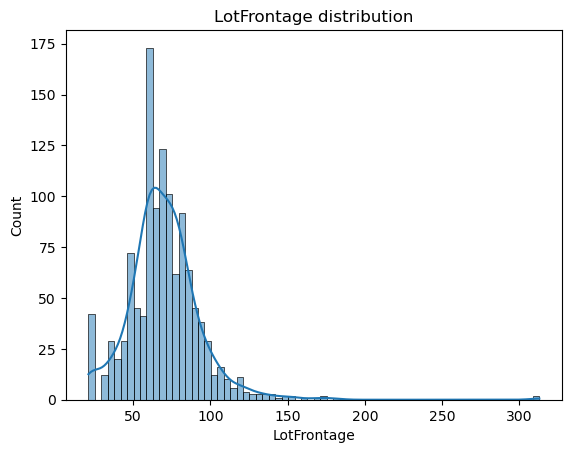

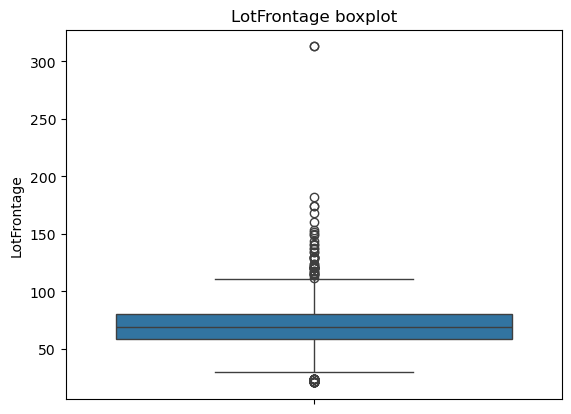

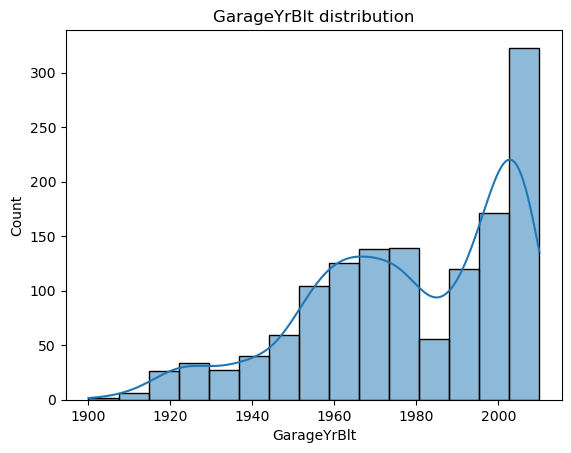

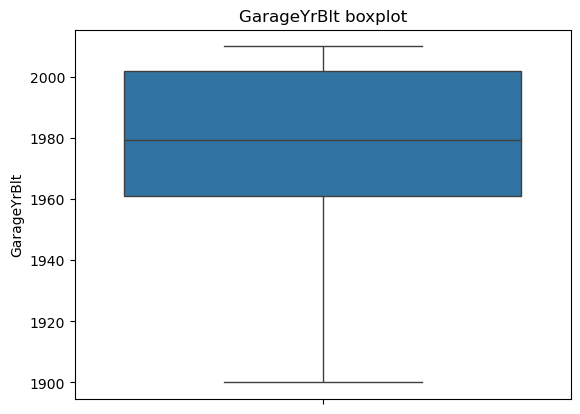

In [89]:
for n in num:
    sns.histplot(df[n],kde=True)
    plt.title(f'{n} distribution')
    plt.show()
    sns.boxplot(df[n])
    plt.title(f'{n} boxplot')
    plt.show()

In [90]:
x=df.drop(columns=['SalePrice'])
from sklearn.impute import SimpleImputer
mean=SimpleImputer(strategy='mean')
median=SimpleImputer(strategy='median')
x[num[1]]=mean.fit_transform(x[[num[1]]])
x[num[0]]=mean.fit_transform(x[[num[0]]])

In [91]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler,RobustScaler
from sklearn.pipeline import Pipeline

num_cols=x.select_dtypes(exclude='object').columns
cat_cols=x.select_dtypes(include='object').columns
num_pipeline=Pipeline(steps=[
    
    ('scaler',RobustScaler())
])
cat_pipeline=Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('encoder',OneHotEncoder())
])
preprocessor=ColumnTransformer(transformers=[
    ('num',num_pipeline,num_cols),
    ('cat',cat_pipeline,cat_cols)
])
df_encoded=preprocessor.fit_transform(x)


In [92]:
x=df_encoded.toarray()
y=np.log1p(df['SalePrice'])

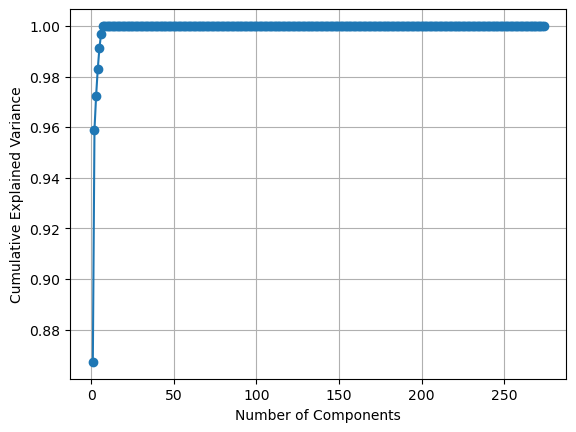

In [93]:
from sklearn.decomposition import PCA
pca=PCA()
pca.fit(x)
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), 
         pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid()
plt.show()

In [94]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from torchmetrics import MeanSquaredError


In [95]:
class MyDataset(Dataset):
    def __init__(self,feature,target):
        self.x=torch.tensor(feature,dtype=torch.float32)
        self.y=torch.tensor(target.values.astype(np.float32),dtype=torch.float32).view(-1,1)
    def __getitem__(self, index):
        return self.x[index],self.y[index]
    def __len__(self):
        return self.x.shape[0]
class Net(nn.Module):
    def __init__(self,n_features):
        super().__init__()
        self.layer=nn.Sequential(
            nn.Linear(n_features,256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            
            nn.Linear(256,128),
            nn.ReLU(),
            
            nn.Linear(128,1)
        )
    def forward(self,x):
        return self.layer(x)


In [96]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=18)

In [97]:

train_data=MyDataset(x_train,y_train)
train=DataLoader(train_data,batch_size=64,shuffle=True)
model=Net(x.shape[1])
criterion=nn.SmoothL1Loss()
optim=optim.Adam(model.parameters(),lr=0.003)


In [98]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Net(
  (layer): Sequential(
    (0): Linear(in_features=274, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [99]:
loss_list=[]
for epoch in range(400):
    model.train()
    running_loss=0
    total_samples=0
    for features,labels in train:
        features=features.to(device)
        labels=labels.to(device)
        optim.zero_grad()
        outputs=model(features)
        loss=criterion(outputs,labels)
        loss.backward()
        optim.step()
        running_loss+=np.sqrt(loss.item()*labels.size(0))
        total_samples+=labels.size(0)
    epoch_loss=running_loss/total_samples
    loss_list.append(epoch_loss)
    


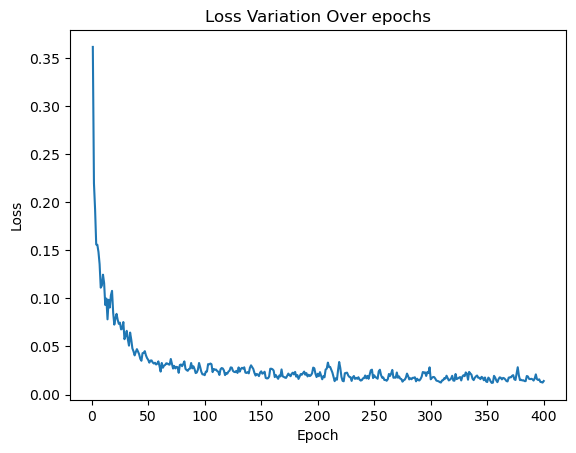

In [100]:
lossdf=pd.DataFrame({'epoch':list(range(1,401)),'loss':loss_list})
sns.lineplot(lossdf,x='epoch',y='loss')
plt.title('Loss Variation Over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [101]:
test_data=MyDataset(x_test,y_test)
test=DataLoader(test_data,batch_size=32,shuffle=True)
mse=MeanSquaredError().to(device)
model.eval()
with torch.no_grad():
    for features,target in test:
        features=features.to(device)
        target=target.to(device)
        outputs=model(features)
        outputs=torch.expm1(outputs)
        target=torch.expm1(target)
        mse.update(outputs,target)
    mse_value=mse.compute()
    rmse_value=torch.sqrt(mse_value)
print(rmse_value)
rmse_value=rmse_value/df['SalePrice'].mean()*100
print(f'My model is ~{rmse_value:.2f}% off an average')

tensor(46004.9609, device='cuda:0')
My model is ~25.47% off an average


In [102]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100, 300, 500, 1000],
    "max_depth": [None, 10, 20, 30, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
    "bootstrap": [True, False]
}
rfcv=GridSearchCV(RandomForestRegressor(),param_grid,scoring='neg_root_mean_squared_error',n_jobs=-1,cv=5)
rfcv.fit(x_train,y_train)
print(f'Best Parmas: {rfcv.best_params_} with a score of :{rfcv.best_score_}')

Best Parmas: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000} with a score of :-0.15049972587203925


28178.975399042683
My model is ~15.60% off an average


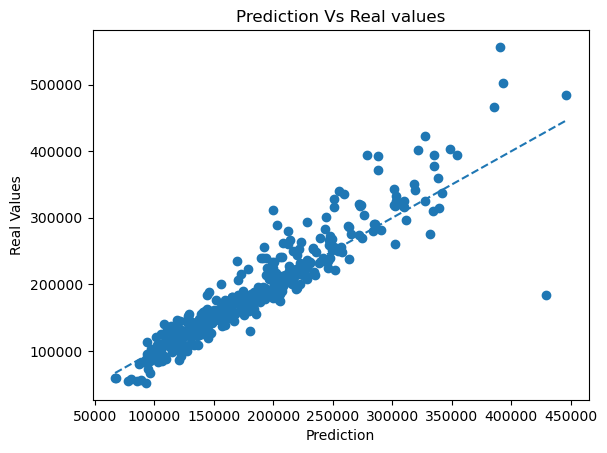

In [103]:
from sklearn.metrics import mean_squared_error as MSE
rf=rfcv.best_estimator_

pred=rf.predict(x_test)
pred=np.expm1(pred)
rmse_value=np.sqrt(MSE(pred,np.expm1(y_test)))
print(rmse_value)
rmse_value=rmse_value/df['SalePrice'].mean()*100
print(f'My model is ~{rmse_value:.2f}% off an average')
def show(pred,y_test):
    plt.scatter(x=pred,y=np.expm1(y_test))
    plt.title('Prediction Vs Real values')
    plt.xlabel('Prediction')
    plt.ylabel('Real Values')
    plt.plot([pred.min(),pred.max()],[pred.min(),pred.max()],ls='--')
    plt.show()
show(pred,y_test)

In [104]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
xgb_param_grid = {
    'learning_rate': [ 0.1],
    'max_depth': [ 5],
    'min_child_weight': [2],
    'subsample': [0.7],
    'colsample_bytree': [ 0.9,1],
    'gamma': [0],
    'reg_alpha': [0.5],  
    'reg_lambda': [0.5], 
    'n_estimators': [ 200],
}

xgb_cv=GridSearchCV(XGBRegressor(tree_method="hist", device="cuda"),xgb_param_grid,scoring='neg_root_mean_squared_error',n_jobs=-1,cv=5)
xgb_cv.fit(x_train,y_train)
print(f'Best Parmas: {xgb_cv.best_params_} with a score of :{xgb_cv.best_score_}')

Best Parmas: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 200, 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'subsample': 0.7} with a score of :-0.14029010797069116


27684.956910420195
My model is ~15.33% off an average


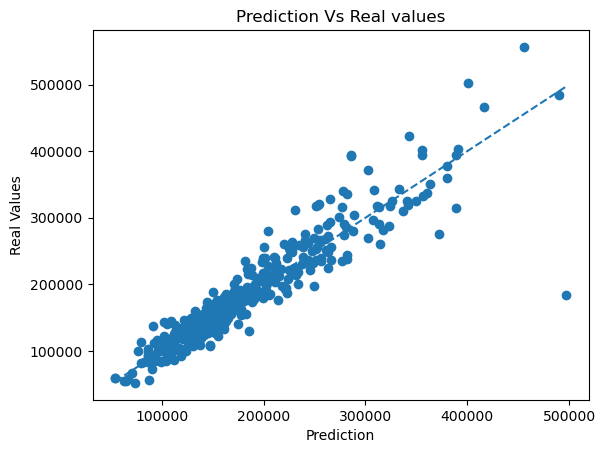

In [105]:
xgb=xgb_cv.best_estimator_
pred=xgb.predict(x_test)
pred=np.expm1(pred)
rmse_value=np.sqrt(MSE(pred,np.expm1(y_test)))
print(rmse_value)
rmse_value=rmse_value/df['SalePrice'].mean()*100
print(f'My model is ~{rmse_value:.2f}% off an average')
show(pred,y_test)

As You can See a tuned XGBoost preform better than RF and NN

In [106]:
from lime.lime_tabilar import LimeTabularExplainer

ModuleNotFoundError: No module named 'lime'